# Example pipeline for SASSIE realtime campaign

Jinbo Wang <Jinbo.Wang@jpl.nasa.gov>

June, 12, 2022

Data source (from Kyla's list)

1. SSS: SMAP JPL 8-day running mean (link). 
2. SST: NOAA Optimum Interpolation 1/4 Degree Daily Sea Surface Temperature (OISST) Analysis (if possible, possibly tricky since this is a NOAA product) (link)
3a. Sea ice concentration: AMSR-E/AMSR2 Unified L3 Daily 12.5 km Brightness Temperatures, Sea Ice Concentration (link) that is currently implemented in SOTO. 
3b. Sea ice extent: Multisensor Analyzed Sea Ice Extent (MASIE) 4km sea ice extent (link). (This is a binary ice/no-ice product)
4) Wind speed (ideally vectors, but I understand this will take time to implement; wind speed alone is nonetheless helpful): MetOp-A/ASCAT (which is currently implemented in SOTO).
5) Surface current speed (again, vectors would be preferred but speed is still helpful). OSCAR (currently implemented in SOTO). 


In [12]:
import xarray as xr
import pylab as plt
def direct_s3():
    import requests,s3fs
    temp_creds_url = 'https://archive.podaac.earthdata.nasa.gov/s3credentials'
    creds = requests.get(temp_creds_url).json()
    s3 = s3fs.S3FileSystem(anon=False,
                           key=creds['accessKeyId'],
                           secret=creds['secretAccessKey'], 
                           token=creds['sessionToken'])
    return s3

In [2]:
sn_sss='SMAP_JPL_L3_SSS_CAP_8DAY-RUNNINGMEAN_V5'
sn_sst='MW_IR_OI-REMSS-L4-GLOB-v5.0'
sn_oscar='OSCAR_L4_OC_NRT_V2.0'

In [3]:
s3=direct_s3()
podaac_s3='podaac-ops-cumulus-protected'

In [4]:
fns_sss=sorted(s3.glob(podaac_s3+'/%s/2022/*/*nc'%sn_sss))[-10:] #the 10 most recent files
fns_sst=sorted(s3.glob(podaac_s3+'/%s/*nc'%sn_sst))[-10:]
fns_oscar=sorted(s3.glob(podaac_s3+'/%s/*nc'%sn_oscar))[-10:]

In [5]:
for aa in [fns_sss,fns_sst,fns_oscar]:
    print(aa[-1])

podaac-ops-cumulus-protected/SMAP_JPL_L3_SSS_CAP_8DAY-RUNNINGMEAN_V5/2022/150/SMAP_L3_SSS_20220603_8DAYS_V5.0.nc
podaac-ops-cumulus-protected/MW_IR_OI-REMSS-L4-GLOB-v5.0/20220609120000-REMSS-L4_GHRSST-SSTfnd-MW_IR_OI-GLOB-v02.0-fv05.0.nc
podaac-ops-cumulus-protected/OSCAR_L4_OC_NRT_V2.0/oscar_currents_nrt_20220609.nc


## Load data

In [6]:
sss=xr.open_dataset(s3.open(fns_sss[-5]))
sst=xr.open_dataset(s3.open(fns_sst[-1]))
oscar=xr.open_dataset(s3.open(fns_oscar[-1]))
u=xr.DataArray(oscar['u'][0,...].T,dims=('lat','lon'),
               coords={'lat':oscar['lat'].data,'lon':oscar['lon'].data})
v=xr.DataArray(oscar['v'][0,...].T,dims=('lat','lon'),
               coords={'lat':oscar['lat'].data,'lon':oscar['lon'].data})


## SST

In [7]:
print(sst)

<xarray.Dataset>
Dimensions:           (lat: 2048, lon: 4096, time: 1)
Coordinates:
  * lat               (lat) float32 -89.96 -89.87 -89.78 ... 89.78 89.87 89.96
  * lon               (lon) float32 -180.0 -179.9 -179.8 ... 179.8 179.9 180.0
  * time              (time) datetime64[ns] 2022-06-09T12:00:00
Data variables:
    analysed_sst      (time, lat, lon) float32 ...
    analysis_error    (time, lat, lon) float32 ...
    sea_ice_fraction  (time, lat, lon) float32 ...
    mask              (time, lat, lon) float32 ...
Attributes: (12/47)
    Conventions:                CF-1.6,ACDD-1.3
    title:                      Analysed foundation sea surface temperature o...
    summary:                    A merged, multi-sensor L4 foundation SST prod...
    references:                 http://www.remss.com/measurements/sea-surface...
    institution:                REMSS
    history:                    2022-06-12 00:32:58+0000 created by fuse_sens...
    ...                         ...
    proj

<div class="alert alert-block alert-warning">
    Improvement: use leaflet module for interactive viewing
</div>

## SSS
<div class="alert alert-block alert-warning">
    Latitude range is from North to South. This will break the xarray sel feature. 
</div>

In [8]:
sss

<xarray.Dataset>
Dimensions:               (latitude: 720, longitude: 1440, time: 1)
Coordinates:
  * latitude              (latitude) float32 89.88 89.62 89.38 ... -89.62 -89.88
  * longitude             (longitude) float32 -179.9 -179.6 ... 179.6 179.9
  * time                  (time) datetime64[ns] 2022-05-30T12:00:00
Data variables:
    smap_sss              (latitude, longitude) float32 ...
    anc_sss               (latitude, longitude) float32 ...
    anc_sst               (latitude, longitude) float32 ...
    smap_spd              (latitude, longitude) float32 ...
    smap_high_spd         (latitude, longitude) float32 ...
    weight                (latitude, longitude) float32 ...
    land_fraction         (latitude, longitude) float32 ...
    ice_fraction          (latitude, longitude) float32 ...
    smap_sss_uncertainty  (latitude, longitude) float32 ...
Attributes: (12/40)
    title:                       SMAP 0.25x0.25 deg grid averaged 8-day SSS/WSPD
    institution:                 Jet Propulsion Laboratory
    source:                      SMAP L2B SSS
    history:                     DATA_SOURCE_VERSION V5.0 L2B SMAP SSS/WSPD
    comment:                     Gaussian-weighted map gridding of SMAP L2B S...
    Gaussian_window_radius:      45.0
    ...                          ...
    creator_name:                JPL
    creator_email:               fore@jpl.nasa.gov
    publisher_name:              Alexander G. Fore
    publisher_email:             fore@jpl.nasa.gov
    contributor_name:            Alexander Fore, Simon Yueh, Wenqing Tang, Ak...
    references:                  10.1109/TGRS.2016.2601486, 10.1109/TGRS.2016...

## OSCAR

In [9]:
oscar

<xarray.Dataset>
Dimensions:  (latitude: 719, longitude: 1440, time: 1)
Coordinates:
    lat      (latitude) float64 -89.75 -89.5 -89.25 -89.0 ... 89.25 89.5 89.75
    lon      (longitude) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time     (time) object 2022-06-09 00:00:00
Dimensions without coordinates: latitude, longitude
Data variables:
    u        (time, longitude, latitude) float64 ...
    v        (time, longitude, latitude) float64 ...
    ug       (time, longitude, latitude) float64 ...
    vg       (time, longitude, latitude) float64 ...
Attributes: (12/36)
    title:                      Ocean Surface Current Analyses Real-time (OSC...
    summary:                    Global, daily, 0.25 degree geostrophic and to...
    keywords:                   ocean currents,ocean circulation,surface curr...
    Conventions:                CF-1.8 Standard Names v77, ACDD-1.3, netcdf 4...
    id:                         OSCAR_L4_OC_NRT_V2.0
    history:                    OSCAR 0.25 degree daily version 2.0 replaces ...
    ...                         ...
    geospatial_lon_max:         359.75
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.25 degree
    time_coverage_start:        2022-06-09T00:00:00
    time_coverage_end:          2022-06-09T23:59:59
    date_created:               2022-06-12

## Domain 

In [15]:
lon0,lon1=-170,-125
lat0,lat1=67,74

sss0=sss['smap_sss'].sel(longitude=slice(lon0,lon1)).sel(latitude=slice(lat1,lat0))
sst0=sst['analysed_sst'][0,...].sel(lon=slice(lon0,lon1)).sel(lat=slice(lat0,lat1))-273.15
u0=u.sel(lon=slice(lon0+360,lon1+360)).sel(lat=slice(lat0,lat1))
v0=v.sel(lon=slice(lon0+360,lon1+360)).sel(lat=slice(lat0,lat1))

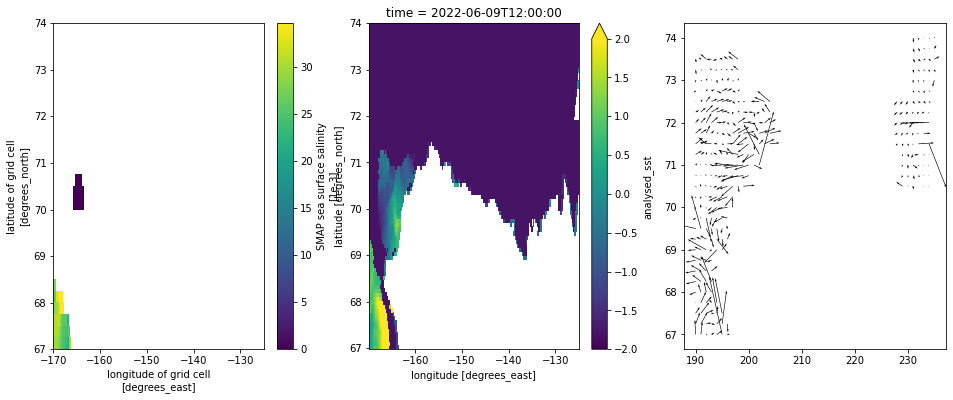

In [16]:
fig,ax=plt.subplots(1,3,figsize=(16,6))

sss0.plot(ax=ax[0])
sst0.plot(ax=ax[1],vmin=-2,vmax=2)
ax[2].quiver(u0.lon[::4],u0.lat,u0.data[:,::4],v0.data[:,::4],scale=3,angles='uv')